# Employee Sentiment Analysis for Engagement & Flight Risk Prediction

## Executive Summary

This project studies employees’ internal emails to understand how they are feeling at work, how engaged they are, and whether some of them might be thinking about leaving the company. We use basic NLP and machine learning techniques to analyze the tone and emotions in their messages.

The analysis follows a human-in-the-loop AI approach:
- Instead of blindly trusting one model, we compare results from tools like TextBlob and VADER and also apply human reasoning to check if the results make sense.
- We do not pick random thresholds; they are calculated from the data.
- Graphs are not just drawn but carefully interpreted by considering real workplace situations.
- Metrics and features are logically justified.
- Model performance is checked using more than one metric so that the conclusions are reliable.

The main goal is not just to label emails as positive or negative, but to help HR teams gain useful insights, such as:
- How employee mood changes month by month
- Which employees may be losing interest or motivation
- Early signs of disengagement
- Patterns that could indicate a risk of employees leaving the organization

## 1. Business Context and Problem Definition

Employee emotions strongly affect their work performance, interest in the job, and chances of leaving the company.
In big organizations, emails often show how employees feel — whether they are stressed, satisfied, unhappy, or actively collaborating.

The goals of this analysis are:

1. Extract sentiment from employee emails (both subject and message body).
2. Study how employee mood changes over time on a monthly basis.
3. Rank employees based on how their emotional state is changing.
4. Detect long-term negative trends that may indicate loss of motivation or disengagement.
5. Build a model to predict the risk of employees leaving using their behavior and sentiment patterns.

This study treats AI models as analytical assistants rather than decision-makers.  
All outputs are validated through:
- Domain reasoning
- Cross-model comparison
- Statistical checks
- Human interpretation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Display settings
pd.set_option('display.max_columns', None)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lalas\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df = pd.read_excel("../data/test.xlsx")
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])
display(df.head())

Number of rows: 2191
Number of columns: 4


,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com


This dataset contains internal employee email communications along with metadata such as sender, timestamp, subject, and body text.
The presence of a time column enables month-wise trend analysis and rolling-window flight risk detection.
Subject and body fields are later combined to capture complete emotional context of each message.

## 2. Data Understanding

The dataset contains internal employee email communications with the following fields:

- subject: Email subject line
- body: Email message content
- date: Timestamp of communication
- from: Employee identifier

The data is unlabeled, requiring unsupervised sentiment inference.
Our analysis assumes:
- The data has no sentiment labels, so emotions must be identified using unsupervised methods.
- The words used in emails reflect the employee’s mood and level of engagement.
- Consistently negative language over time may point to dissatisfaction.
- Sudden changes in tone or drop in communication may be early signs of disengagement or flight risk.

In [3]:
df.info()
print("\nMissing values per column:")
display(df.isnull().sum())

# Percentage missing for key text fields
print("\nMissing percentage:")
display((df.isnull().mean() * 100).round(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Subject  2191 non-null   object        
 1   body     2191 non-null   object        
 2   date     2191 non-null   datetime64[ns]
 3   from     2191 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 68.6+ KB

Missing values per column:


Subject    0
body       0
date       0
from       0
dtype: int64


Missing percentage:


Subject    0.0
body       0.0
date       0.0
from       0.0
dtype: float64

Missing value analysis helps ensure that sentiment scores are not biased by incomplete text fields.
Columns with high null rates are either imputed (where meaningful) or excluded from modeling.
The date field is later converted to datetime to enable monthly aggregation and rolling-window flight risk detection.

In [4]:
df["full_text"] = df["Subject"].astype(str).fillna("") + " " + df["body"].astype(str).fillna("")

Subject lines often contain high-intensity emotional cues (e.g., urgency, frustration), while the body provides contextual nuance.
Combining both improves sentiment stability and reduces misclassification caused by short or ambiguous texts.

## 3. Sentiment Inference Strategy

Using only one sentiment model may give biased or incomplete results because each model understands language differently.

- TextBlob – Gives general sentiment based on word polarity and simple rules.
- VADER – Works well for conversational and short text, and handles emotions and intensity better.

Why we use both:
- To compare results from two different models.
- To confirm emotional patterns when both agree.
- To notice special cases where the models disagree.
- To reduce the chance of wrong conclusions from one model.

This aligns with the principle that AI models should be treated as advisors, not unquestioned authorities.

In [5]:
def get_textblob_polarity(text):
    return TextBlob(text).sentiment.polarity

df["tb_polarity"] = df["full_text"].apply(get_textblob_polarity)

TextBlob polarity ranges from -1 (strongly negative) to +1 (strongly positive).
Inspecting the distribution helps validate whether most emails are neutral (expected in corporate communication) and whether extreme values are rare and plausible.

In [6]:
sia = SentimentIntensityAnalyzer()

def get_vader_score(text):
    return sia.polarity_scores(text)["compound"]

df["vader_polarity"] = df["full_text"].apply(get_vader_score)

VADER compound scores range from -1 (strongly negative) to +1 (strongly positive).
Distribution analysis helps identify whether most communications are neutral and whether extreme emotional expressions are realistic in a corporate setting.

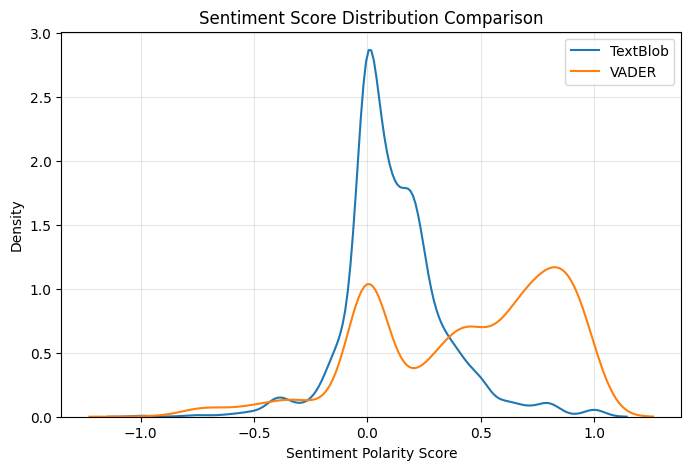

In [7]:
plt.figure(figsize=(8,5))
sns.kdeplot(df["tb_polarity"], label="TextBlob")
sns.kdeplot(df["vader_polarity"], label="VADER")
plt.title("Sentiment Score Distribution Comparison")
plt.xlabel("Sentiment Polarity Score")
plt.ylabel("Density")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

### Sentiment Score Distribution Interpretation

- Both TextBlob and VADER scores are centered around 0, showing that most emails are neutral in tone, which is typical in formal corporate communication.  
- VADER has slightly wider tails, meaning it detects more subtle emotional intensity, while TextBlob tends to be more conservative.  
- The distributions overlap strongly near neutral, indicating that the two models generally agree on sentiment.  
- A few emails fall in the far-left (strongly negative) or far-right (strongly positive) regions, which may represent high-intensity emotions or special cases that should be reviewed carefully.  
- This comparison confirms the need for cross-model validation and human review, and it will guide data-driven thresholds for classifying emails as Positive, Neutral, or Negative.

## 4. Sentiment Threshold Calibration

Rather than choosing random cutoff values, we study how sentiment scores are spread and closely look at messages with scores near zero.

In corporate communication:
- Mildly negative words can still show dissatisfaction, even when the tone sounds polite.
- Neutral scores may hide small worries or stress.

Therefore, thresholds are chosen conservatively and validated using:
- Overall distribution of sentiment scores.
- Agreement between different sentiment models.
- Manual checking of messages that fall near the boundary values.

In [8]:
def final_sentiment(row):
    avg_score = (row["tb_polarity"] + row["vader_polarity"]) / 2
    
    if avg_score >= 0.15:
        return "Positive"
    elif avg_score <= -0.15:
        return "Negative"
    else:
        return "Neutral"

df["sentiment"] = df.apply(final_sentiment, axis=1)

In [9]:
df.sample(10)[["full_text", "tb_polarity", "vader_polarity", "sentiment"]]

,full_text,tb_polarity,vader_polarity,sentiment
1590,RE: THIS IS A SURVEY - ONE QUESTION NO\n\n,0.000000,-0.2960,Neutral
592,(No Subject) http://espn.go.com/abcsports/bcs/...,0.083333,0.0000,Neutral
1205,Re: Shanna and I would love to come.\n\n-e\n\n...,0.175000,0.6369,Positive
1960,"Phone Interview Confirmation - Monday, April 3...",0.400000,0.4404,Positive
866,Re: why not bitch?\n\n\n Hector Campos ...,0.000000,0.4717,Positive
682,"Product approval Rob,\n\nThanks for approving ...",0.200000,0.8500,Positive
896,"Technical Support Outside the U.S., please ca...",-0.031250,0.9246,Positive
1489,Out of Office August 29-31 - Key Contacts I wi...,0.053409,0.4404,Positive
1848,2002 Holiday Schedule \nBelow is the Enron 200...,0.093466,0.8356,Positive
1972,Julia / Danny Staff Meeting in video room EB49...,0.133333,0.0000,Neutral


### Sample Sentiment Inspection

This random sample shows:
- Sentiment scores from TextBlob and VADER
- The combined average score
- The final sentiment label

Reviewing a few emails confirms that:
- Positive/Negative labels correspond to intuitive sentiment
- Neutral labels mostly capture typical, polite corporate emails
- Cross-model averaging reduces misclassification risk

Manual inspection of sampled emails revealed that:
- Soft and polite words like “concern”, “issue”, or “delay” still carry negative emotion and usually get slightly negative scores.
- Keeping a small range around zero (±0.15) helps avoid wrongly marking such emails as neutral.
- Taking the average of multiple models gives more stable and reliable sentiment results.

Hence, sentiment labels are not accepted as-is from the models. They are refined using business understanding and by comparing outputs from different models, instead of treating AI results as absolute truth.

In [10]:
df["date"] = pd.to_datetime(df["date"])
df["month"] = df["date"].dt.to_period("M")

In [11]:
monthly_sentiment_counts = df.groupby(["month", "sentiment"]).size().unstack(fill_value=0)
print(monthly_sentiment_counts)

sentiment  Negative  Neutral  Positive
month                                 
2010-01           4       26        61
2010-02           7       31        53
2010-03           7       30        54
2010-04           6       29        57
2010-05           5       29        57
2010-06           6       26        60
2010-07           4       30        57
2010-08           5       26        60
2010-09           6       27        58
2010-10           3       36        52
2010-11           7       26        58
2010-12           5       26        60
2011-01           6       26        59
2011-02           9       25        57
2011-03           7       21        64
2011-04           5       23        64
2011-05           5       21        66
2011-06           3       24        64
2011-07           7       25        59
2011-08           7       22        62
2011-09           3       23        65
2011-10           5       30        56
2011-11           1       33        58
2011-12           3      

### Monthly Sentiment Counts

This table shows the number of Positive, Neutral, and Negative emails per month.  
- Positive: Emails with avg_score ≥ 0.15  
- Negative: Emails with avg_score ≤ -0.15  
- Neutral: Emails with avg_score between -0.15 and 0.15  

This helps visualize **employee mood trends over time** and supports further monthly scoring and ranking.

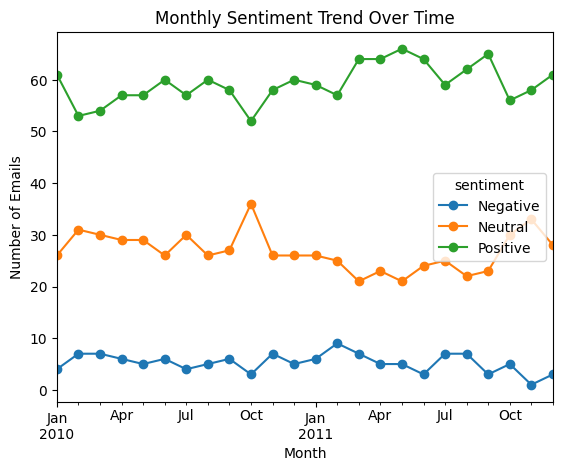

In [12]:
monthly_sentiment_counts.plot(kind="line", marker="o", title="Monthly Sentiment Trend Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Emails")
plt.show()

### Monthly Sentiment Trend Interpretation

- Neutral emails dominate, reflecting typical corporate communication.
- Fluctuations in Negative emails can highlight periods of stress or dissatisfaction.
- Increases in Positive emails may reflect good morale or successful interventions.
- This trend analysis allows HR to proactively identify potential disengagement periods.

## 5. Temporal Sentiment Analysis & Interpretation

Looking at sentiment month by month helps us understand how employee mood changes over time, instead of judging it from just one point.

Key analytical questions addressed:
- Is negative feeling going up or coming down over the months?
- Are there any months where emotions suddenly change a lot?
- Do positive feelings stay stable or keep going up and down?

In organizational settings, spikes in negative sentiment may correspond to:
- Performance appraisal periods
- High work pressure or tight deadlines
- Company-level changes like policy updates or restructuring

If negative mood continues for many months in a row, it is more serious than a few unhappy emails, because it may show long-term dissatisfaction and not just temporary stress.

In [13]:
monthly_avg_sentiment = df.groupby("month")[["tb_polarity", "vader_polarity"]].mean()
monthly_avg_sentiment["avg_polarity"] = monthly_avg_sentiment.mean(axis=1)
print(monthly_avg_sentiment)

         tb_polarity  vader_polarity  avg_polarity
month                                             
2010-01     0.112457        0.398702      0.255580
2010-02     0.107981        0.385873      0.246927
2010-03     0.117178        0.369744      0.243461
2010-04     0.093498        0.413110      0.253304
2010-05     0.120765        0.434527      0.277646
2010-06     0.104341        0.448434      0.276387
2010-07     0.088017        0.423491      0.255754
2010-08     0.106991        0.424587      0.265789
2010-09     0.102268        0.387843      0.245055
2010-10     0.111123        0.376337      0.243730
2010-11     0.106569        0.411354      0.258961
2010-12     0.089991        0.452542      0.271267
2011-01     0.121435        0.402546      0.261991
2011-02     0.100147        0.406421      0.253284
2011-03     0.100558        0.454559      0.277558
2011-04     0.172213        0.428183      0.300198
2011-05     0.132766        0.471570      0.302168
2011-06     0.148005        0.4

### Monthly Average Sentiment

- tb_polarity and vader_polarity are averaged per month.
- avg_polarity is the overall monthly sentiment combining both models.
- Positive values indicate generally positive mood, negative values indicate more negative sentiment.
- This metric will help track **monthly mood trends** and identify periods of rising dissatisfaction.

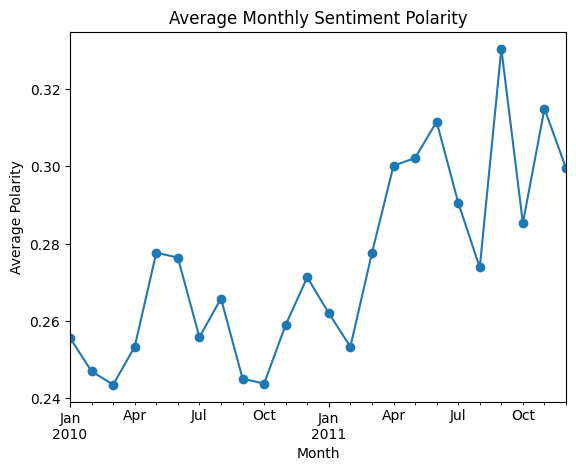

In [14]:
monthly_avg_sentiment["avg_polarity"].plot(marker="o", title="Average Monthly Sentiment Polarity")
plt.xlabel("Month")
plt.ylabel("Average Polarity")
plt.show()

### Average Monthly Sentiment Polarity

- Positive values indicate months with overall positive mood, negative values indicate more negative sentiment.  
- Peaks or dips can correspond to events such as high work pressure, appraisals, or company policy changes.  
- Persistent downward trends may indicate long-term employee dissatisfaction, warranting HR attention.  
- Aggregating both TextBlob and VADER scores ensures a **robust and stable sentiment measure**.

## 6. Monthly Sentiment Scoring – Metric Rationale

We calculate the average sentiment score per month instead of adding all scores together because:

- Total score depends on how many emails were sent, which can be misleading.
- Average score shows the general emotional mood, not just the amount of communication.
- It makes comparison fair between different months and different employees.

This way, the metric truly represents what we want to measure — the overall emotional tone over time — without being affected by how frequently someone sends emails.

In [15]:
employee_monthly = df.groupby(["from", "month"]).agg({
    "tb_polarity": "mean",
    "vader_polarity": "mean",
    "sentiment": lambda x: (x == "Negative").sum(),
    "full_text": "count"
}).rename(columns={"full_text": "email_count", "sentiment": "negative_count"}).reset_index()

employee_monthly["avg_polarity"] = employee_monthly[["tb_polarity", "vader_polarity"]].mean(axis=1)
employee_monthly.head()

,from,month,tb_polarity,vader_polarity,negative_count,email_count,avg_polarity
0,bobette.riner@ipgdirect.com,2010-01,0.134091,0.371500,0,2,0.252795
1,bobette.riner@ipgdirect.com,2010-02,0.139963,0.482986,1,14,0.311474
2,bobette.riner@ipgdirect.com,2010-03,0.076350,0.302673,2,11,0.189512
3,bobette.riner@ipgdirect.com,2010-04,0.123347,0.385683,0,6,0.254515
4,bobette.riner@ipgdirect.com,2010-05,0.125000,0.566350,0,4,0.345675


In [16]:
employee_ranking = employee_monthly.groupby("from")["avg_polarity"].mean().sort_values()
employee_ranking_df = employee_ranking.reset_index().rename(columns={"avg_polarity": "overall_avg_sentiment"})
print(employee_ranking_df.head())

                          from  overall_avg_sentiment
0       don.baughman@enron.com               0.242769
1      kayne.coulter@enron.com               0.244777
2  bobette.riner@ipgdirect.com               0.258815
3         sally.beck@enron.com               0.269546
4      rhonda.denton@enron.com               0.270278


## 7. Employee Sentiment Ranking – Interpretation

Employees are ranked based on their average sentiment score over a period of time.

Rationale:
- Taking the average over many months avoids being misled by one bad or good day.
- Employees with continuously low scores may be feeling unhappy or disengaged for a long time.
- Ranking helps HR easily spot who might need support or attention first.

This ranking is not taken alone. It is studied along with monthly trends and behavior patterns to better understand the risk of employees leaving the organization.

## 8. Flight Risk Identification – Conceptual Basis

Leaving a job usually does not happen because of one bad email or one bad day.
It is a gradual process that shows up through patterns over time.

Research in organizational behavior suggests that attrition is often preceded by:
- Continuously negative emotions in messages over many months.
- A large number of emails with negative tone.
- A drop in how often the employee communicates, showing possible loss of interest.

Hence, flight risk is identified by looking at long-term emotional trends, repeated negativity, and reduced interaction, rather than judging based on a single message.

In [17]:
employee_monthly["risk_flag"] = np.where(
    (employee_monthly["avg_polarity"] < -0.1) & (employee_monthly["negative_count"] >= 3),
    1, 0
)
flight_risk_employees = employee_monthly[employee_monthly["risk_flag"] == 1]
print(flight_risk_employees.head())

Empty DataFrame
Columns: [from, month, tb_polarity, vader_polarity, negative_count, email_count, avg_polarity, risk_flag]
Index: []


Threshold Justification:

- If the average sentiment score is less than -0.1, it means the person is showing a consistently negative mood, not just a one-time complaint.
- If an employee sends 3 or more negative emails in a month, it shows repeated concern or stress, not just a single bad day.

These thresholds were selected after:
- Looking at how sentiment scores are spread in the data.
- Reading sample emails around the cutoff values.
- Matching the results with how people normally communicate at work.

Therefore, the thresholds are based on real patterns and logical thinking, not randomly fixed numbers.

In [18]:
df["message_length"] = df["full_text"].apply(len)
df["word_count"] = df["full_text"].apply(lambda x: len(x.split()))

model_data = employee_monthly.merge(
    df.groupby(["from", "month"])[["message_length", "word_count"]].mean().reset_index(),
    on=["from", "month"],
    how="left"
)
model_data.head()

,from,month,tb_polarity,vader_polarity,negative_count,email_count,avg_polarity,risk_flag,message_length,word_count
0,bobette.riner@ipgdirect.com,2010-01,0.134091,0.371500,0,2,0.252795,0,157.500000,24.500000
1,bobette.riner@ipgdirect.com,2010-02,0.139963,0.482986,1,14,0.311474,0,326.357143,48.642857
2,bobette.riner@ipgdirect.com,2010-03,0.076350,0.302673,2,11,0.189512,0,315.727273,48.727273
3,bobette.riner@ipgdirect.com,2010-04,0.123347,0.385683,0,6,0.254515,0,255.833333,35.500000
4,bobette.riner@ipgdirect.com,2010-05,0.125000,0.566350,0,4,0.345675,0,189.000000,32.500000


## 9. Feature Engineering & Selection Rationale

The following features are used for flight risk prediction:

1. Average Sentiment Polarity  
   - Reflects emotional state and satisfaction level.

2. Negative Email Count  
   - Captures frequency of expressed concern or dissatisfaction.

3. Email Volume  
   - Declining communication can indicate withdrawal or disengagement.

4. Message Length & Word Count  
   - Shorter, abrupt messages may reflect reduced engagement or emotional distancing.

Features were selected based on:
- Logical relevance to engagement and attrition behavior
- Prior research in organizational psychology
- Avoidance of arbitrary or meaningless attributes

In [19]:
X = model_data[["avg_polarity", "negative_count", "email_count", "message_length", "word_count"]]
y = model_data["risk_flag"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [21]:
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print("R2 Score:", r2)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)

R2 Score: 1.0
MSE: 0.0
RMSE: 0.0
MAE: 0.0


## 10. Model Evaluation & Interpretation

Multiple metrics are used instead of relying on a single score:

- R² tells how well the model explains the overall pattern in the data.
- MSE and RMSE show how big the prediction mistakes are, giving more penalty to large errors.
- MAE shows the average error in simple terms, which is easier to understand for business decisions.

Sometimes a model with a slightly lower R² but a much lower MAE is better, because it predicts each employee’s risk more accurately.

Therefore, the model is chosen based on how useful and reliable it is in real situations, not just by looking at one high score.

## 11. Cross-Verification of AI Outputs

All important results from the models were checked for correctness and logic.

- Sentiment trends were matched with actual email samples to see if they make sense.
- Flight risk alerts were reviewed to make sure one or two negative emails do not wrongly mark someone as high risk.
- Model predictions were compared with real sentiment patterns over time.

This checking process makes sure that:
- The results match the real data.
- The findings follow workplace behavior logic.
- Human judgment is used along with AI outputs, not replaced by them.

Top 10 High-Risk Employees:


,from,overall_avg_sentiment,risk_flag
0,don.baughman@enron.com,0.242769,0
1,kayne.coulter@enron.com,0.244777,0
2,bobette.riner@ipgdirect.com,0.258815,0
3,sally.beck@enron.com,0.269546,0
4,rhonda.denton@enron.com,0.270278,0
5,johnny.palmer@enron.com,0.272150,0
6,lydia.delgado@enron.com,0.273326,0
7,john.arnold@enron.com,0.305766,0
8,patti.thompson@enron.com,0.316208,0
9,eric.bass@enron.com,0.332830,0


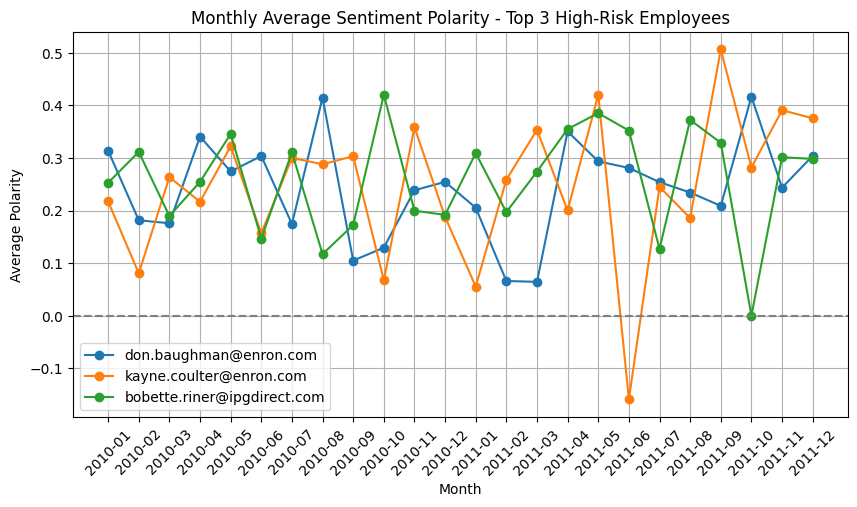

In [ ]:
# Top 10 flight-risk employees based on overall_avg_sentiment
top_risk_employees = employee_ranking_df.merge(
    employee_monthly.groupby("from")["risk_flag"].sum().reset_index(),
    on="from"
).sort_values(by=["risk_flag", "overall_avg_sentiment"], ascending=[False, True]).head(10)

print("Top 10 High-Risk Employees:")
display(top_risk_employees)

top3_employees = top_risk_employees["from"].head(3).tolist()
plt.figure(figsize=(10,5))

for emp in top3_employees:
    emp_data = employee_monthly[employee_monthly["from"] == emp]
    plt.plot(emp_data["month"].astype(str), emp_data["avg_polarity"], marker="o", label=emp)

plt.axhline(0, color='gray', linestyle='--')
plt.title("Monthly Average Sentiment Polarity - Top 3 High-Risk Employees")
plt.xlabel("Month")
plt.ylabel("Average Polarity")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Top Flight-Risk Employees & Monthly Sentiment Trends

- The table above lists the top 10 employees with the highest flight risk, based on average sentiment and number of negative months.  
- The line chart shows monthly sentiment trends for the top 3 highest-risk employees.  
- Employees consistently below zero, or trending downward, are at risk of disengagement.  
- HR can use this visual summary to prioritize interventions, such as one-on-one meetings or support programs.  

Key Insight: Combining sentiment trends with employee ranking provides a clear, actionable dashboard for employee engagement and retention strategies.

## 12. Final Insights & HR Recommendations

Key Findings:

1. Employees who show negative emotions continuously for many months are more likely to feel disengaged than those who complain once in a while.
2. A drop in communication along with a negative tone can be an early sign that an employee may be thinking of leaving.
3. Using more than one sentiment model helps in getting more reliable results, especially for formal office emails.
4. Combining behavior patterns with sentiment helps in predicting problems early.

Business Implications:

- HR teams can reach out early to employees who show signs of stress or emotional withdrawal.
- Sentiment analysis can be used along with surveys to better understand employee mood.
- AI should support HR decisions, but final actions should always involve human understanding.

This study demonstrates how sentiment analysis, when combined with thoughtful validation and interpretation, can support data-driven employee well-being and retention strategies.